# Perceptron
The Perceptron is a simple single-neuron model for binary classification. Given two categories of items (e.g., dogs vs humans, chairs vs stools), the Perceptron learns how to use their properties (e.g., weight, volume, number of legs) to distinguish between the two. Below, we demonstrate an implementation of the Perceptron to distinguish between two LEGO set themes.

The first step is to import relevant libraries. `from ipynb.fs.defs.Neuron import SingleNeuron` imports the `SingleNeuron` abstract class from our `Neuron.ipynb` file. The `pandas` and `numpy` libraries are useful for data processing. The `matplotlib`, `seaborn`, and `mlxtend` libraries are useful for graphs and visualization.

In [1]:
from ipynb.fs.defs.Neuron import SingleNeuron
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

## Data processing
We wish to analyze the dataset `Brickset-Most-Owned-Query-33-02042023.csv`. This dataset is located at https://brickset.com/sets/query-33. It contains data for many LEGO sets, like 10243: Parisian Restaurant and 21309: NASA Apollo Saturn V. Foreach set, there is data related to its theme, release year, number of minifigures, number of pieces, monetary price, height/width/depth dimensions, and weight.

We want to train our Perceptron to distinguish between "Duplo" theme and "Bionicle" theme LEGO sets based on the number of pieces in the set and the weight of the set. We label each Duplo row with a +1 indicator and each Bionicle row with a -1 indicator. The Perceptron will detect the theme by outputing a +1 if it thinks it found a Duplo set and a -1 if it thinks it found a Bionicle set.

In [11]:
# Read in dataset and keep relevant columns/rows
df = pd.read_csv('data/Brickset-Most-Owned-Query-33-02042023.csv')
df = df.filter(["Number", "Theme", "Pieces", "Weight"])
df = df[(df["Theme"] == "Duplo") | (df["Theme"] == "Bionicle")]
df = df.dropna()

# Assign +1 indicator for Duplo and -1 indicator for Bionicle
df["Indicator"] = np.where(df["Theme"] == "Duplo", 1, -1)

# Print out some properties of the dataframe
n_sample = len(df.index)
print(df)
print("There are ", n_sample, " observations.")
print("There are ", np.sum(df["Theme"] == "Duplo"), " Duplo sets.")
print("There are ", np.sum(df["Theme"] == "Bionicle"), " Bionicle sets.")

(409, 4)
       Number     Theme  Pieces   Weight  Indicator
770    8759-1  Bionicle   856.0  2.24000         -1
780    8996-1  Bionicle   849.0  1.59000         -1
1110   8943-1  Bionicle   693.0  1.53000         -1
1155   8927-1  Bionicle   674.0  1.50000         -1
1231   8894-1  Bionicle   648.0  1.70000         -1
...       ...       ...     ...      ...        ...
13781  5643-1     Duplo     4.0  0.06000          1
13994  5678-1     Duplo     4.0  0.06000          1
14029  2198-1     Duplo     3.0  0.21000          1
14136  4632-1     Duplo     3.0  0.25000          1
14384  2304-1     Duplo     1.0  0.26332          1

[409 rows x 5 columns]
There are  409  observations.
There are  276  Duplo sets.
There are  133  Bionicle sets.


We've now identfied our dataset! We now need to format our data in such a way that we can use it to train the Perceptron. For our data on $n$ data points, we need our input signal (our Pieces and Weights values) to be in a $(n, 2)$-shape array. We need our Duplo/Bionicle indicators in a $(n, 1)$-shape array.

To properly constract a machine learning model, we should partition our data into three sets:
1. Training data. Used to train the model parameters.
2. Testing data. Used to test the performance of model types to help select for model features.
3. Validation data. Used after the model has been fully trained. The fully-trained model should be applied to the validation data to see how the model would perform on data that it has never seen before.

However, for simplicity so that we can focus on illustrating the Perceptron, we will treat all our data as training data for this example.

In [3]:
X_train = df.filter(["Pieces", "Weight"]).values.reshape(-1, 2)
y_train = df["Indicator"].values.reshape(-1, 1)

## Perceptron neuron
We can finally begin implementing the Perceptron. We will implement the `SingleNeuron` abstract class as a Perceptron by giving it the appropriate `activation`, `update`, and `cost_function` methods. See `Neuron.ipynb` for more information about the single-neuron model.

Let $w \in \mathbb{R}^2$ represent the neuron weights and $b \in \mathbb{R}$ represent the neuron bias. For data point $i$ with input signal $x \in \mathbb{R}^2$ and indicator $y_i \in \{-1, 1\}$, the activation function $\phi$ should take in the input preactivation value $z_i = w \cdot x_i + b$ and output +1 if it thinks the input signal belongs to a Duplo set and -1 if it thinks the input signal belongs to a Bionicle set. The sign function is a natural way to output $\pm1$: $\phi(z_i) = 1$ if $z > 0$, else $\phi(z_i) = -1$.

The cost function of the Perceptron is the number of incorrect predictions it makes each epoch. The goal is to minimize this cost function. As the neuron's prediction for data point $i$ is equal to $\hat y_i = \phi(z_i) = \phi(w \cdot x_i + b)$, we can formulate this cost function as $c(w, b) = \sum\limits_{i \in [n]} (\hat y_i \neq y_i)$, where $(\hat y_i \neq y_i) = 1$ if $\hat y_i \neq y_i$ and $(\hat y_i \neq y_i) = 0$ if $\hat y_i = y_i$.

The update function changes the weights and bias to try increase prediction accuracy. We use the following rule to update after each prediction on data point $i$:
1. $w \gets w - \frac{1}{2} (\hat y_i - y_i) x_i$
2. $b \gets b - \frac{1}{2} (\hat y_i - y_i)$

### Why does the update function work?
Suppose the Perceptron made the right prediction $\hat y_i = y_1$. Then, $w, b$ performed well and are not changed.

Suppose the Perceptron guessed +1 when the correct indicator is -1. Then, $w \gets w - x_i$, which means in future epochs $z_i = w \cdot x_i + b$ will yield a more negative value, hopefully causing $\hat y_i = \phi(z_i) = -1$. ($w \gets w - x_i$ is akin to increasing the angle between $w, x_i$, reducing their cosine similarity.)

Similarly, suppose the Perceptron guessed -1 when the correct indicator is +1. Then, $w \gets w + x_i$, which means in future epochs $z_i = w \cdot x_i + b$ will yield a more positive value, hopefully causing $\hat y_i = \phi(z_i) = +1$.

In [4]:
class Perceptron(SingleNeuron):
    '''
    Implementation of abstract SingleNeuron class as a Perceptron.
    '''
    def activation(self, preactivation):
        '''
        RETURNS the +/- sign of the preactivation value.
        '''
        return 2 * (preactivation > 0) - 1
    
    def update(self, actual, predicted, signal):
        '''
        Updates the model weights using the Perceptron update rule for the prediction on a given data point
        INPUT
            actual; the observed actual indicator y_i
            predicted; the predicted indicator yhat_i
            signal; the input signal x_i
        '''
        self.weights = self.weights - 1/2 * (predicted - actual) * np.transpose(signal)
        self.bias = self.bias - 1/2 * (predicted - actual)

    def cost_function(self, actual, predicted, signal):
        '''
        INPUT
            actual; the observed actual indicator y_i
            predicted; the predicted indicator yhat_i
            signal; the input signal x_i
        OUTPUT
            1 if actual = predicted, else 0
        '''
        return(actual != predicted)

We can now train our implemented Perceptron model. We define an instance of the Perceptron, and then we train the instance using the data we identified earlier. We have arbitrarily chosen to train for 600 epochs (i.e., we are training the Perceptron on the entire dataset 600 times). 

In [5]:
mdl = Perceptron()
n_epoch = 600
errors = mdl.train(X_train, y_train, n_epoch=n_epoch)

Cost: 8.0: 100%|██████████| 600/600 [00:08<00:00, 67.46it/s]  


## Model performance
Let's visualize our model's performance as it trains. `errors` stores the number of false predictions each epoch. We can plot `errors` as a time series to see how our error rate improves as the number of training epochs increases.

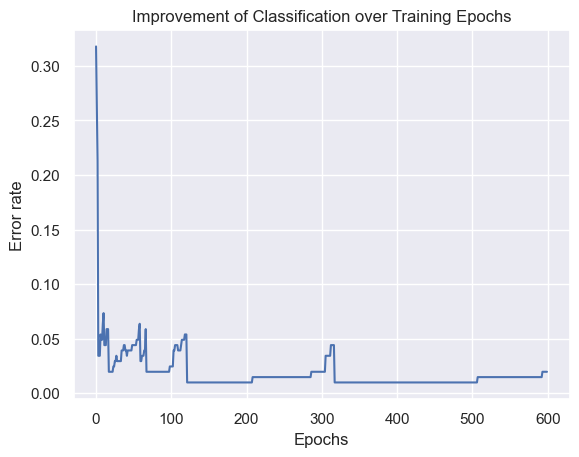

Error rate after last epoch: 0.019559902200488997


In [6]:
sns.set_theme()
plt.plot([err / n_sample for err in errors])
plt.title("Improvement of Classification over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error rate")
plt.show()
print("Error rate after last epoch:", errors[-1] / n_sample)

As expected, the error rate declines as the number of training epochs increases. As we train the Perceptron, the weights and bias parameters are gradually tuned to make more accurate predictions. At the end of the 600th epoch, the Perceptron made inaccurate predictions only 2.7% of the time.

Let's see the model's decision boundary. A decision boundary is the threshold for input signal values such that any input signal greater than the threshold are considered to be Duplo, and any input signal lesser than the threshold are considered to be Bionicle.

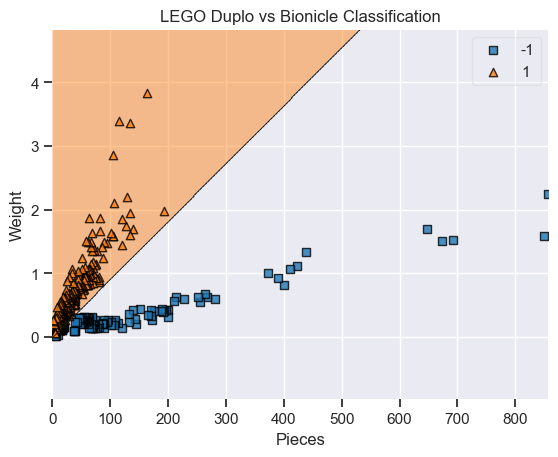

In [7]:
plot_decision_regions(X_train, y_train.reshape((-1,)), clf=mdl)
plt.title("LEGO Duplo vs Bionicle Classification")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

The +1 triangles are Duplo sets, and the -1 squares are Bionicle sets. The decision boundary shows that heavy sets with few pieces are likely to be Duplo, and lighter sets with more pieces are likely to be Bionicle. This makes intuitive sense: Duplo LEGO sets are marketed toward younger children and thus have fewer, larger pieces. Bionicle sets are intricate action figures with many small moving parts.

As a last step, let's look at how the decision boundary changes as the model trains. This lets us visualize the improvement of the model over time The classification is weak in the first few epochs but steadily improves. There is signficant drop-off in improvement after the first few dozen epochs.

Cost: 6.0: 100%|██████████| 500/500 [00:08<00:00, 59.19it/s] 


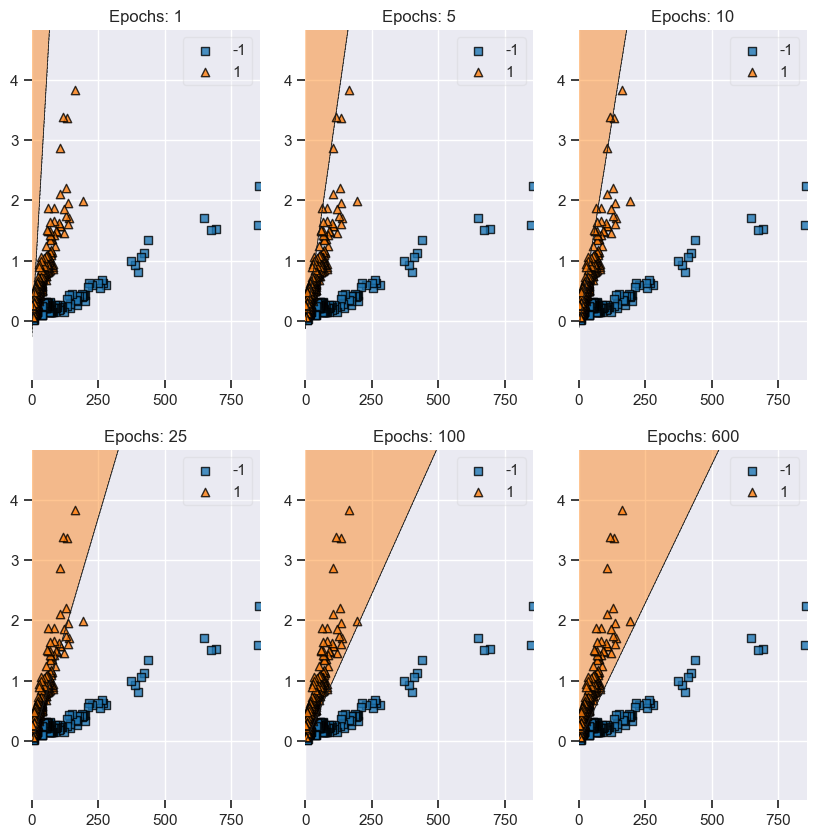

In [8]:
# List of epochs to plot progress at
epochs = [1, 5, 10, 25, 100, 600]

# Reset model to default weights
mdl.weights = np.zeros(mdl.weights.shape)

# Create subplots of each tested learning rate
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(10, 10))

# Train model, plotting decision boundary at each designated epoch count
trained_epochs = 0
for ind in range(len(epochs)):
    
    # Compute number of epochs to train
    epoch_batch = epochs[ind] - trained_epochs
    trained_epochs += epoch_batch

    # Train model
    mdl.train(X_train, y_train, n_epoch=epoch_batch)
    
    # Plot decision boundary
    ax = plt.subplot(gs[int(ind / 3), ind % 3])
    fig = plot_decision_regions(X_train, y_train.reshape((-1,)), clf=mdl)
    ax.set_title("Epochs: " + str(trained_epochs))